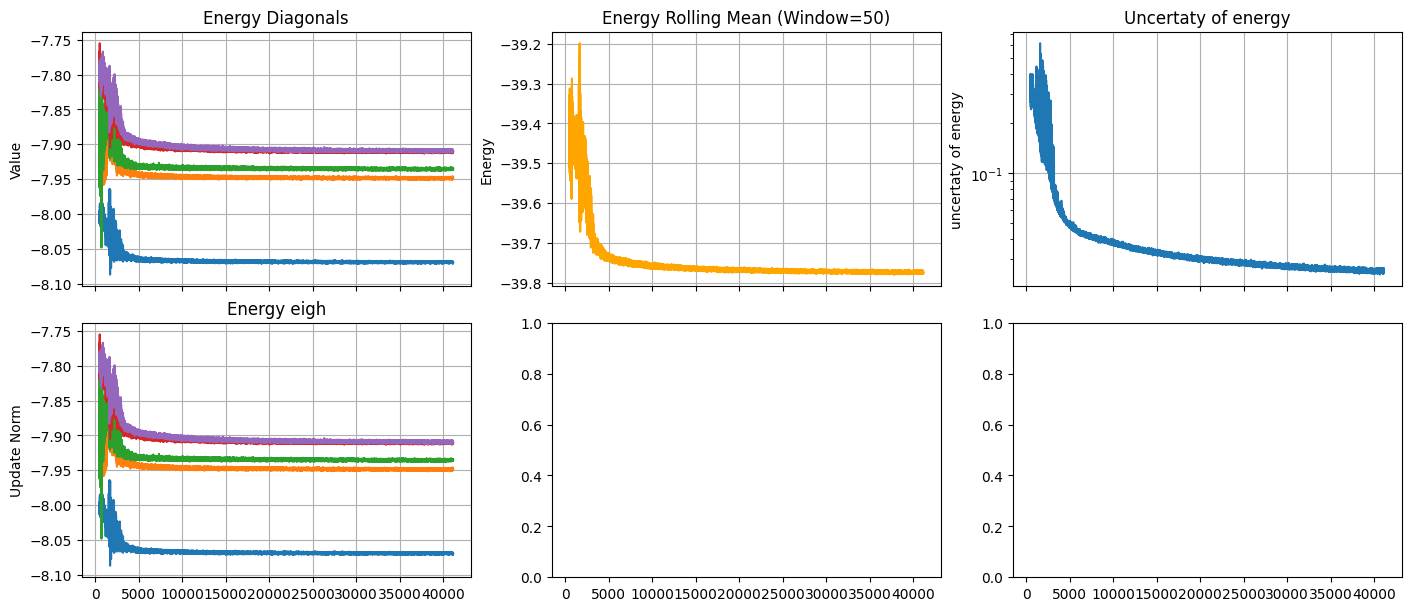

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(fname):
  """Load the arrays from a file and take the average and variance.

  Args:
    fname: Name of file to load.
    tail: If 0, load all arrays in the file. If n !=0, load the last n arrays.

  Returns:
    Average value of the arrays in the file and the variance.
  """
  datas = []
  with open(fname, "rb") as f:
    fsize = os.fstat(f.fileno()).st_size
    out = np.load(f)
    datas.append(out)
    arr_size = f.tell()
    fsize -= fsize % arr_size  # cut off any half-saved data
    n = fsize // arr_size
    for _ in (range(n-1)):
      out = np.load(f)
      datas.append(out)
  return datas

root_path = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/Overlap/Mol_ferminet/LiH/'
# root_path = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_ferminet/H2O/'


data = pd.read_csv(root_path+sorted(os.listdir(root_path))[-1])
data = data.set_index('step')
data = data.reset_index()

energy_matrixs = load_data(root_path+'energy_matrix.npy')
energy_matrixs_clip = load_data(root_path+'energy_matrix_clip.npy')
energy_matrix_clip_std = load_data(root_path+'energy_matrix_clip_std.npy')
# Es = np.array([np.diagonal(e) for e in energy_matrixs])
# Es_clip = np.array([np.diagonal(e) for e in energy_matrixs_clip])
# Es_clip1 = np.array([sorted(np.linalg.eig(e)[0]) for e in energy_matrixs_clip])
# Es_clip_std = np.array([np.diagonal(e) for e in energy_matrix_clip_std])

Es = np.array(energy_matrixs)
Es_clip = np.array(energy_matrixs_clip)
Es_clip1 = np.array(energy_matrixs_clip)
Es_clip_std = np.array(energy_matrix_clip_std)

# E_m = np.array(energy_matrixs_clip)[-1000:,:,:]
# E,U=np.linalg.eigh(E_m.mean(0))
# E1 = sorted(np.diagonal(E_m.mean(0)))
# print('本征值：', E, E-E[0])
# print('对角元素：', np.array(E1), E1-E1[0])
# # 创建紧凑的子图布局，例如 3 行 2 列，且共享 x 轴
fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)

length = min([len(energy_matrixs_clip), data.shape[0], len(energy_matrix_clip_std)])
# length = 20000
star_index = 500
star_index1 = star_index
star_index2 = star_index
end_index = length
end_index1 = length
end_index2 = length

# 子图 1: Es 的绘图
axes[0, 0].plot(data['step'][star_index1:end_index1], Es_clip[star_index:end_index], alpha=1)
axes[0, 0].set_title('Energy Diagonals')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True)

# 子图 2: energy 的滚动平均（示例中使用 window=50 进行平滑）
# axes[0, 1].plot(data['energy'].rolling(window=1).mean()[star_index:end_index], color='orange')
axes[0, 1].plot(data['step'][star_index1:end_index1], Es_clip[star_index:end_index].sum(1), alpha=1, color='orange')
axes[0, 1].set_title('Energy Rolling Mean (Window=50)')
axes[0, 1].set_ylabel('Energy')
axes[0, 1].grid(True)

# 子图 3: var 的滚动平均开方（示例中使用 window=50 进行平滑）
# axes[0, 2].plot(((data['var'].rolling(window=1).mean())**0.5)[star_index:end_index], color='green')
axes[0, 2].plot(data['step'][star_index2:end_index2], Es_clip_std[star_index:end_index].mean(1), alpha=1)
axes[0, 2].set_title('Uncertaty of energy')
axes[0, 2].set_ylabel('uncertaty of energy')
axes[0, 2].set_yscale("log")
axes[0, 2].grid(True)

# 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 0].plot(data['step'][star_index1:end_index1], Es_clip1[star_index:end_index])
axes[1, 0].set_title('Energy eigh')
axes[1, 0].set_ylabel('Update Norm')
axes[1, 0].grid(True)

# # 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
# axes[1, 1].plot(data['update_norm'].rolling(window=1).mean().iloc[star_index:end_index], color='red')
# axes[1, 1].set_title('Update Norm Rolling Mean (Last 7000, Window=50)')
# axes[1, 1].set_ylabel('Update Norm')
# axes[1, 1].set_yscale("log")
# axes[1, 1].grid(True)

# # 子图 5: grad_norm 的滚动平均（取最后 7000 个点，window=50）
# axes[1, 2].plot(data['grad_norm'].rolling(window=1).mean().iloc[star_index:end_index], color='purple')
# axes[1, 2].set_title('Grad Norm Rolling Mean (Last 7000, Window=50)')
# axes[1, 2].set_ylabel('Grad Norm')
# axes[1, 2].set_xlabel('Index')
# axes[1, 2].set_yscale("log")
# axes[1, 2].grid(True)

# 隐藏子图 6（如果不需要）
# fig.delaxes(axes[1, 2])

plt.show()

In [117]:
E = Es_clip[-300:].mean(0)
print(E, E - E[0])

[-8.069161  -7.9485326 -7.935471  -7.9101667 -7.9089656] [0.         0.12062883 0.13369036 0.15899467 0.16019583]


In [88]:

import jax.numpy as jnp


for E_m in energy_matrixs:
    E_m = E_m.reshape(4096,5,5)

    lower_bound  = jnp.percentile(E_m, 1, axis=0)
    upper_bound  = jnp.percentile(E_m, 99, axis=0)

    # 筛选不含异常值的矩阵
    mask = jnp.all((E_m >= lower_bound) & (E_m <= upper_bound), axis=(1, 2))
    valid_matrices = E_m[mask]

    # 输出筛选后的矩阵数量
    print("符合条件的矩阵数量:", valid_matrices.shape[0])


符合条件的矩阵数量: 3552
符合条件的矩阵数量: 3542
符合条件的矩阵数量: 3552
符合条件的矩阵数量: 3528
符合条件的矩阵数量: 3530
符合条件的矩阵数量: 3590
符合条件的矩阵数量: 3626
符合条件的矩阵数量: 3542
符合条件的矩阵数量: 3618
符合条件的矩阵数量: 3588
符合条件的矩阵数量: 3558
符合条件的矩阵数量: 3574


In [120]:
energy_matrixs = load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_psiformer/LiH_ci/energy_matrix.npy')

In [ ]:
energy_matrixs[3]

array([[[[ -5.9323845 ,   0.70549774,  -1.6681137 ,  -1.1077751 ,
            0.54653496],
         [ -3.1024566 ,  -5.9075317 ,  -1.0633922 ,   0.69726384,
            4.623872  ],
         [ -2.7205367 ,  -1.9747915 ,  -5.7950177 ,   0.21905863,
            5.864425  ],
         [  0.93581283,   2.5324683 ,   0.14334989,  -5.2495813 ,
           -5.5486455 ],
         [ -3.3986485 ,  -0.52798796,  -1.7626009 ,  -1.4212581 ,
            0.34697187]],

        [[ -2.1038513 ,  -0.8716141 ,  -0.23503804,   0.58594936,
           -0.8528862 ],
         [  0.86739165,  -4.8162394 ,   2.8097682 ,   1.1472099 ,
            0.10179394],
         [ -0.07029986,  -2.9113014 ,   2.06854   ,   1.3071193 ,
           -0.87649   ],
         [  1.0294948 ,   4.886821  ,  -9.422978  ,  -5.7012644 ,
           -0.1408537 ],
         [ -1.3835251 ,  -3.2206876 ,   8.94862   ,   3.34835   ,
           -3.6292207 ]],

        [[ -0.7032201 ,   2.5018713 ,  -6.868124  ,  -4.8602705 ,
           -1.099683

In [128]:
jnp.mean(energy_matrixs[3], axis=(0,1))

Array([[-3.0464103 ,  0.4690801 , -0.35058472, -0.32744122, -0.28016216],
       [ 0.82195795, -2.645321  , -0.7530315 , -0.14546326,  0.3117631 ],
       [ 0.41326165,  0.19418886, -3.56422   , -0.24782805,  0.346456  ],
       [ 0.433881  ,  0.79343164, -0.8950805 , -3.5276713 , -0.51466227],
       [ 0.2589443 , -0.01699745,  0.16888675, -0.09777485, -2.8511758 ]],      dtype=float32)

Neucleus energy: 1.327090184125 a.u.
Active alpha orbitals: [9, 10]
Active beta orbitals: [9, 10]
Number of alpha configurations: 1
Number of beta configurations: 1
Total number of configurations: 1

CASSCF Iteration 1
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 3.419064e+00, Delta Beta: 3.419064e+00

CASSCF Iteration 2
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 1.709532e+00, Delta Beta: 1.709532e+00

CASSCF Iteration 3
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 8.547660e-01, Delta Beta: 8.547660e-01

CASSCF Iteration 4
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 4.273830e-01, Delta Beta: 4.273830e-01

CASSCF Iteration 5
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 2.136915e-01, Delta Beta: 2.136915e-01

CASSCF Iteration 6
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 1.068458e-01, Delta Beta: 1.068458e-01

CASSCF Iteration 7
CI Ground State Energy: -4.247344405273 a.u.
Delta Alpha: 5.342288e-02, Delta B

AssertionError: 

In [ ]:
-4.247344405273

2

In [163]:
data = pd.read_csv('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_ferminet/LiH1/train_stats2024_10_25_14:26:33.csv')

In [165]:
data

,Unnamed: 0,step,time,energy,var,ewmean,ewvar,pmove,grad_norm,learning_rate,momentum,param_norm,precon_grad_norm,update_norm,mu_x,mu_y,mu_z,s2
0,0,0,49.674717,-36.669033,61.654670,-36.669033,-0.000000,0.930625,414.366730,0.050000,0.0,73.436710,6.194522,0.309726,14.825322,-0.103084,0.045307,3.159482
1,0,1,1.409839,-36.451880,35.463184,-36.647316,0.004244,0.934375,249.074160,0.049995,0.0,73.437090,6.511984,0.325567,14.831408,-0.100735,0.045635,4.155509
2,0,2,0.703856,-36.356834,57.108955,-36.618267,0.011414,0.934482,322.606500,0.049990,0.0,73.438270,5.840831,0.291983,14.841450,-0.094009,0.048534,3.715071
3,0,3,0.686041,-36.433357,51.643950,-36.599777,0.013350,0.935166,241.046020,0.049985,0.0,73.440674,6.335486,0.316679,14.837200,-0.092577,0.045118,3.205190
4,0,4,0.684144,-36.397655,29.884232,-36.579567,0.015691,0.935288,322.936830,0.049980,0.0,73.443480,6.206931,0.310222,14.841471,-0.091478,0.039401,4.937252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,199995,0.687605,-39.785416,0.006372,-39.785908,0.000004,0.538052,0.023855,0.002390,0.0,76.071610,0.902730,0.002157,14.277414,-0.121555,-0.070531,6.000312
199996,0,199996,0.685953,-39.787006,0.005352,-39.786020,0.000004,0.539595,0.018676,0.002390,0.0,76.071620,0.825931,0.001974,14.268291,-0.086430,-0.083680,6.000438
199997,0,199997,0.685883,-39.790382,0.024160,-39.786453,0.000005,0.536953,0.021232,0.002389,0.0,76.071630,0.889142,0.002125,14.261206,-0.075763,-0.104244,6.000020
199998,0,199998,0.686704,-39.784958,0.006086,-39.786304,0.000005,0.537124,0.022950,0.002389,0.0,76.071610,0.929499,0.002221,14.276027,-0.047407,-0.109942,5.999867


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
def load_data(fname):
  datas = []
  with open(fname, "rb") as f:
    fsize = os.fstat(f.fileno()).st_size
    out = np.load(f)
    datas.append(out)
    arr_size = f.tell()
    fsize -= fsize % arr_size  # cut off any half-saved data
    n = fsize // arr_size
    for _ in (range(n-1)):
      out = np.load(f)
      datas.append(out)
  return datas
filenames = [
            "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_ferminet/LiH1/",
            "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/Overlap/Mol_ferminet/LiH/"
            ]

E_stds = []
for filename in filenames:
    energy_matrix_clip_std = load_data(filename+'energy_matrix_clip_std.npy')
    Es_clip_std = np.array([np.mean(e) for e in energy_matrix_clip_std])
    Es_clip_std = energy_matrix_clip_std
    E_stds.append(Es_clip_std)

In [97]:
E_stds.pop(-1)
energy_matrix_clip_std = load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/Overlap/Mol_psiformer/LiH1/energy_matrix_clip_std.npy')
Es_clip_std = np.array([np.mean(e) for e in energy_matrix_clip_std])
E_stds.append(energy_matrix_clip_std)

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
def load_data(fname):
  datas = []
  with open(fname, "rb") as f:
    fsize = os.fstat(f.fileno()).st_size
    out = np.load(f)
    datas.append(out)
    arr_size = f.tell()
    fsize -= fsize % arr_size  # cut off any half-saved data
    n = fsize // arr_size
    for _ in (range(n-1)):
      out = np.load(f)
      datas.append(out)
  return datas
# filenames = [
#             "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_ferminet/LiH1/",
#             "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/Overlap/Mol_ferminet/LiH/",
#             "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/Overlap/Mol_psiformer/LiH1/"
#             ]

# E_stds = []
# for filename in filenames:
#     energy_matrix_clip_std = load_data(filename+'energy_matrix_clip_std.npy')
#     Es_clip_std = np.array([np.mean(e) for e in energy_matrix_clip_std])
#     # Es_clip_std = energy_matrix_clip_std
#     E_stds.append(Es_clip_std)

In [179]:
E0=load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Test/ferminet/BH_cassci_diag_ipf/vmctrain/states_0/energy_matrix.npy')
E1=load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Test/ferminet/BH_cassci_diag_ipf/vmctrain/states_1/energy_matrix.npy')
E2=load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Test/ferminet/BH_cassci_diag_ipf/vmctrain/states_2/energy_matrix.npy')

In [314]:
E2=load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Test/ferminet/BH_cassci_diag_ipf/vmctrain/states_2/energy_matrix.npy')

In [167]:
Es0 = []
for i in range(0,len(E0)):
    Es0.append(np.std(E0[i], axis=(0,1,2)))
Es0 = np.array(Es0)
Es1 = []
for i in range(0,len(E1)):
    Es1.append(np.std(E1[i], axis=(0,1,2)))
Es1 = np.array(Es1)

In [315]:
Es2 = []
for i in range(0,len(E2)-100):
    Es2.append(np.std(E2[i:i+100], axis=(0,1,2)))
Es2 = np.array(Es2)

In [ ]:
E2

/tmp/ipykernel_369764/342949764.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


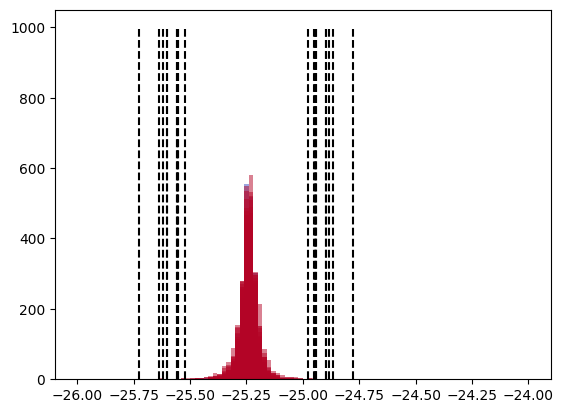

In [317]:
for i in range(0,200000,20000):
    # 设置渐变色
    cmap = plt.cm.get_cmap('coolwarm')
    a = plt.hist(E2[int(len(E2)-i-1)][0] ,bins=100, range= (-26,-24), alpha=0.5, color=cmap(i/20000), label='E2')
    a = np.percentile(E2[int(len(E2)-i-1)][0], [25, 50, 75])
    up = a[1] + 15*(a[2]-a[1])
    low = a[0] - 15*(a[2]-a[1])
    plt.vlines(up, 0, 1000, color='black', linestyles='dashed')
    plt.vlines(low, 0, 1000, color='black', linestyles='dashed')


# plt.xlim(-26,-24)

In [277]:
cmap(0.1)

(np.float64(0.34832334141176474),
 np.float64(0.4657111465098039),
 np.float64(0.8883461629411764),
 np.float64(1.0))

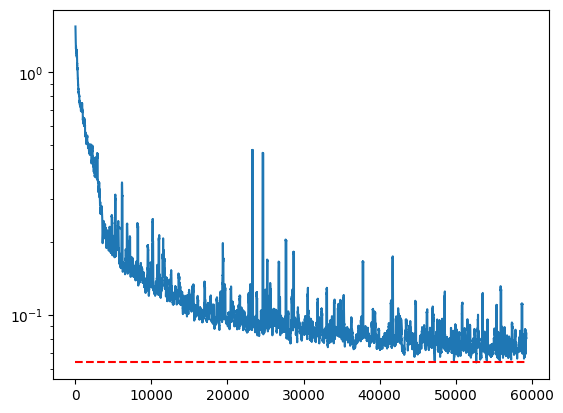

In [211]:
# plt.plot(Es1,label='DFT')
# plt.plot(Es0,label='NNVMC')
plt.plot(Es2,label='DFT')
plt.hlines(0.064,0,len(Es2),colors='r',linestyles='--',label='Threshold')
plt.yscale('log')

In [308]:
x = np.array(E1[20000:21000]).reshape(-1,1)
a = np.percentile(x, [25,75])
stds = []
means = []
for i in range(0,50,1):
    low = a[0] - i*(a[1]-a[0])
    up = a[1] + i*(a[1]-a[0])
    stds.append(np.std(x[(x>low) & (x<up)]))
    means.append(np.mean(x[(x>low) & (x<up)]))
    # a = plt.hist(x[(x>low) & (x<up)], bins=100, alpha=0.5, label='E2')

    # np.mean(x[(x>low) & (x<up)]), np.std(x[(x>low) & (x<up)])

In [313]:
0.0055**0.5/4096**0.5

0.0011587810136086973

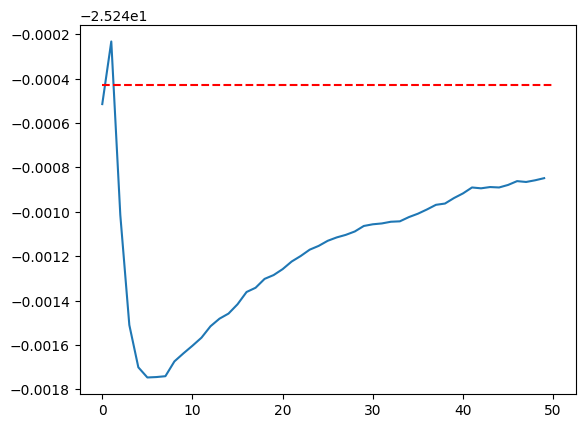

In [ ]:
plt.plot(means)
plt.hlines(y=np.median(x), xmin=0, xmax=len(means), colors='r', linestyles='dashed')

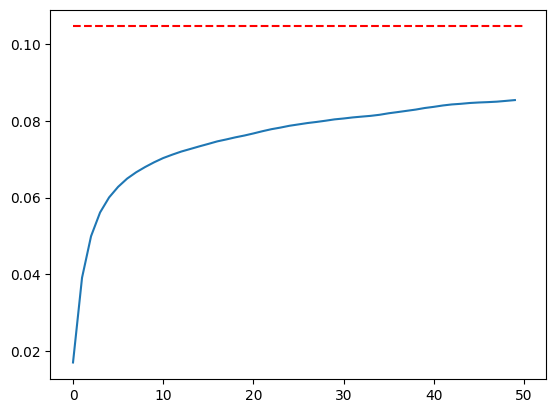

In [310]:
plt.plot(stds)
plt.hlines(np.std(x), 0, len(stds), colors='r', linestyles='dashed')

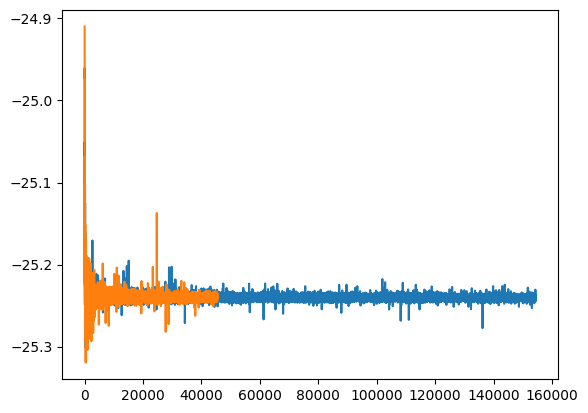

In [190]:
# plt.plot(Es0)
plt.plot(Es)
plt.plot(Es2)

In [131]:
from ferminet import checkpoint

(t_init,
    data,
    params,
    opt_state_ckpt,
    mcmc_width_ckpt,
    density_state_ckpt) = checkpoint.restore(
        '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Test/ferminet/BH_cassci_Psi/pretrain/qmcjax_ckpt_009999.npz', 4096)

In [132]:
data.spins[0][0]

Array([[ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.]], dtype=float32)

In [104]:
writer_kwargs = dict(
    t=1,
    loss=1,
    pmove=1,
    dt = 1,
)
import pandas as pd
pd.DataFrame(writer_kwargs, index=[1])

,t,loss,pmove,dt
1,1,1,1,1


In [96]:
writer_kwargs

{'t': 1, 'loss': 1, 'pmove': 1, 'dt': 1}

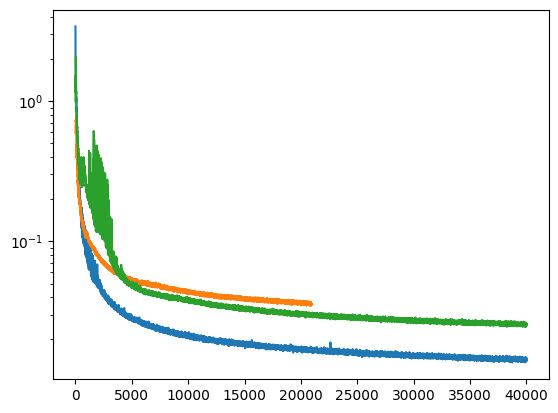

In [125]:
count = 0
for E_std in E_stds:
    plt.plot(E_std[0:40000])
    count += 1
# plt.legend()
plt.yscale('log')
plt.show()

In [49]:
E_stds[0] = np.array(E_stds[0]).reshape(-1,5*5)

/tmp/ipykernel_199488/2384175810.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


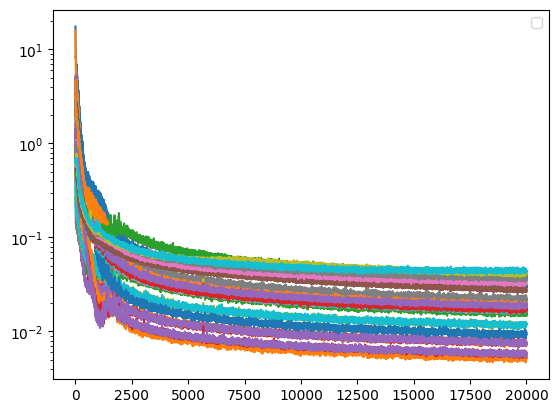

In [51]:
# name = ['ferminet_NES', 'ferminet_overlap']
count = 0
for E_std in E_stds:
    plt.plot(E_std[0:20000])
    count += 1
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
from pyscf import gto, scf, mcscf, fci

mol = gto.Mole()
mol.build(
    verbose = 0,
    atom = 'N, 0., 0., 0. ; N,  0., 0., 1.4',
    basis = 'cc-pvdz',
    symmetry = True,
)
m = scf.RHF(mol)
m.kernel()

ncas = 6
nelec = 6
mc = mcscf.CASSCF(m, 6, 6)
mc.kernel()

# Output all determinants coefficients
print('   det-alpha,    det-beta,    CI coefficients')
occslst = fci.cistring.gen_occslst(range(ncas), nelec//2)
for i,occsa in enumerate(occslst):
    for j,occsb in enumerate(occslst):
        print('   %s       %s      %.12f' % (occsa, occsb, mc.ci[i,j]))

# Only output determinants which have coefficients > 0.05
nelec = (3,3)  # 3 spin-up electrons and 3 spin-down electrons
print('   det-alpha,    det-beta,    CI coefficients')
for c,ia,ib in mc.fcisolver.large_ci(mc.ci, ncas, nelec, tol=.05, return_strs=False):
    print('   %s       %s      %.12f' % (ia, ib, c))

   det-alpha,    det-beta,    CI coefficients
   [0 1 2]       [0 1 2]      -0.918868048191
   [0 1 2]       [0 1 3]      0.000000000000
   [0 1 2]       [0 2 3]      0.000000000000
   [0 1 2]       [1 2 3]      0.000000000000
   [0 1 2]       [0 1 4]      0.000000000000
   [0 1 2]       [0 2 4]      0.000000000000
   [0 1 2]       [1 2 4]      0.000000000000
   [0 1 2]       [0 3 4]      -0.039305013286
   [0 1 2]       [1 3 4]      0.000000000000
   [0 1 2]       [2 3 4]      0.000000000000
   [0 1 2]       [0 1 5]      0.000000000000
   [0 1 2]       [0 2 5]      0.000000000000
   [0 1 2]       [1 2 5]      0.000000000000
   [0 1 2]       [0 3 5]      0.000000000000
   [0 1 2]       [1 3 5]      0.034206739468
   [0 1 2]       [2 3 5]      0.000000000000
   [0 1 2]       [0 4 5]      0.000000000000
   [0 1 2]       [1 4 5]      0.000000000000
   [0 1 2]       [2 4 5]      -0.034206739468
   [0 1 2]       [3 4 5]      0.000000000000
   [0 1 3]       [0 1 2]      0.000000000000
   [0 

In [ ]:
from pyscf import ao2mo
mf = scf.RHF(mol).run()
h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
h2 = ao2mo.kernel(mol, mf.mo_coeff)
e = fci.selected_ci.kernel(h1, h2, mf.mo_coeff.shape[1], mol.nelectron)[0]

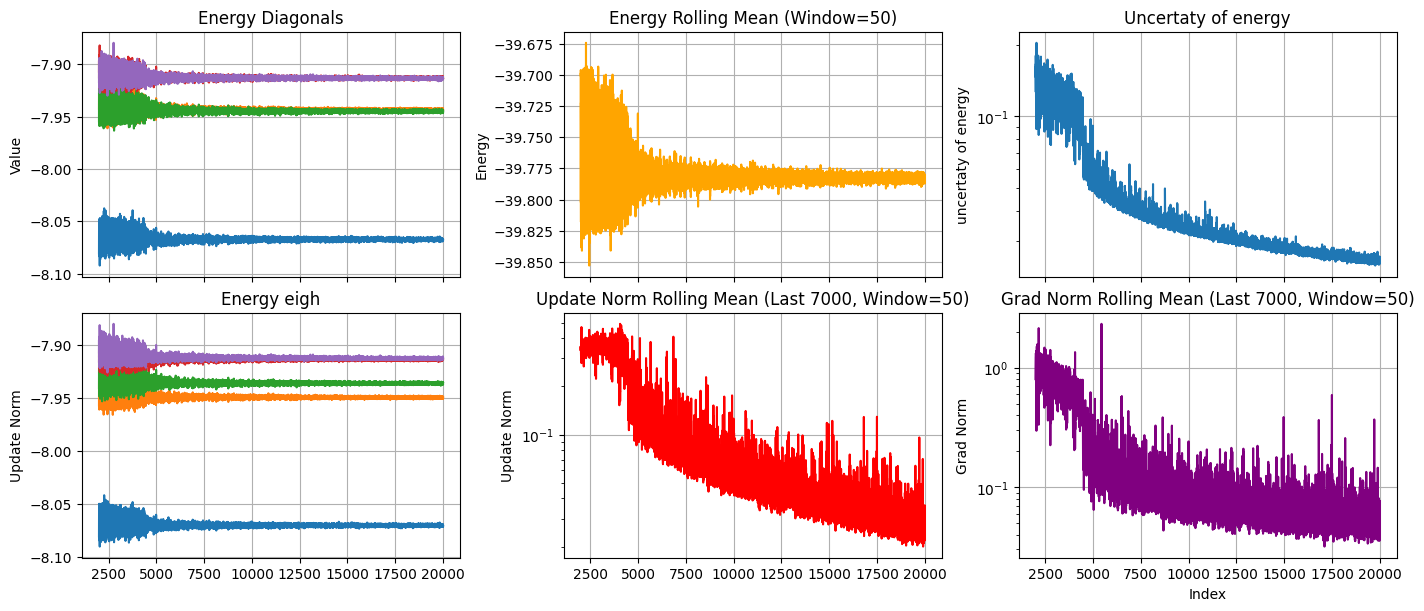

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
length = min([len(energy_matrixs_clip), data.shape[0], len(energy_matrix_clip_std)])
length = 20000
star_index = 2000
star_index1 = star_index
star_index2 = star_index
end_index = length
end_index1 = length
end_index2 = length

# 子图 1: Es 的绘图
axes[0, 0].plot(data['step'][star_index1:end_index1], Es_clip[star_index:end_index], alpha=1)
axes[0, 0].set_title('Energy Diagonals')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True)

# 子图 2: energy 的滚动平均（示例中使用 window=50 进行平滑）
# axes[0, 1].plot(data['energy'].rolling(window=1).mean()[star_index:end_index], color='orange')
axes[0, 1].plot(data['step'][star_index1:end_index1], Es_clip[star_index:end_index].sum(1), alpha=1, color='orange')
axes[0, 1].set_title('Energy Rolling Mean (Window=50)')
axes[0, 1].set_ylabel('Energy')
axes[0, 1].grid(True)

# 子图 3: var 的滚动平均开方（示例中使用 window=50 进行平滑）
# axes[0, 2].plot(((data['var'].rolling(window=1).mean())**0.5)[star_index:end_index], color='green')
axes[0, 2].plot(data['step'][star_index2:end_index2], Es_clip_std[star_index:end_index].mean(1), alpha=1)
axes[0, 2].set_title('Uncertaty of energy')
axes[0, 2].set_ylabel('uncertaty of energy')
axes[0, 2].set_yscale("log")
axes[0, 2].grid(True)

# 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 0].plot(data['step'][star_index1:end_index1], Es_clip1[star_index:end_index])
axes[1, 0].set_title('Energy eigh')
axes[1, 0].set_ylabel('Update Norm')
axes[1, 0].grid(True)

# 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 1].plot(data['update_norm'].rolling(window=1).mean().iloc[star_index:end_index], color='red')
axes[1, 1].set_title('Update Norm Rolling Mean (Last 7000, Window=50)')
axes[1, 1].set_ylabel('Update Norm')
axes[1, 1].set_yscale("log")
axes[1, 1].grid(True)

# 子图 5: grad_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 2].plot(data['grad_norm'].rolling(window=1).mean().iloc[star_index:end_index], color='purple')
axes[1, 2].set_title('Grad Norm Rolling Mean (Last 7000, Window=50)')
axes[1, 2].set_ylabel('Grad Norm')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_yscale("log")
axes[1, 2].grid(True)

plt.show()
# 隐藏子图 6（如果不需要）
# fig.delaxes(axes[1, 2])

In [19]:
data = pd.read_csv('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_ferminet/LiH/train_stats2024_10_25_13:18:49.csv')

<Axes: >

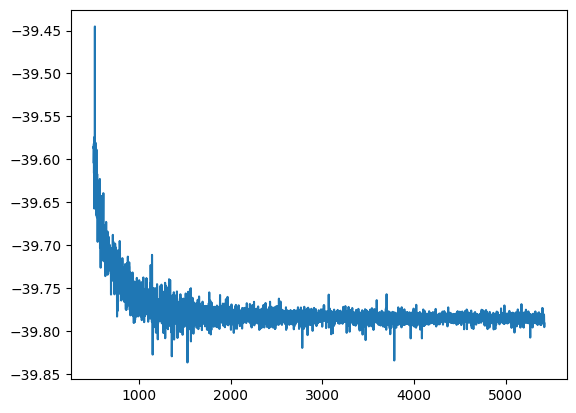

In [20]:
data['energy'].loc[500:22000].plot()

In [33]:
energy_matrixs = load_data('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_psiformer/LiH_test2/energy_matrix.npy')

In [ ]:
from pyscf import gto,scf
import scipy

mol = gto.Mole()
mol.atom = """
Li  0.0  0.0  0.0
H  1.595  0.0  0.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

scf_eng = scf.RHF(mol)
scf_eng.conv_tol = 1e-12
scf_eng.conv_tol_grad = 1e-10
scf_eng.kernel()



In [165]:
Hij = np.zeros((4, 4))
so = [[[0,1],[0,1]],[[0,1],[0,2]],[[0,2],[0,1]],[[0,1],[0,3]]]
for i in range(4):
    for j in range(4):
        # Corrected Density Matrix Update
        D_alpha = Cp[:, so[i][0]] @ Cp[:, so[j][0]].T
        D_beta = Cp[:, so[i][1]] @ Cp[:, so[j][1]].T

        # Corrected Electronic Energy Calculation
        Hij[i,j]=(HC_ortho * (D_alpha + D_beta)).sum() + 0.5 * (
            np.einsum("uvkl, uv, kl ->", eri_ortho, D_alpha + D_beta, D_alpha + D_beta)
            - np.einsum("ukvl, uv, kl ->", eri_ortho, D_alpha, D_alpha)
            - np.einsum("ukvl, uv, kl ->", eri_ortho, D_beta, D_beta)
        ) + E_nuc 

In [153]:
scf_eng = scf.UHF(mol)
scf_eng.conv_tol = 1e-12
scf_eng.conv_tol_grad = 1e-10
scf_eng.kernel()

np.float64(-7.979268948423257)

In [133]:
-7.979268948423262+7.8717

-0.10756894842326226

$$<S^2> = (N_a - N_b)/2 ((N_a - N_b)/2 +1) + N_b+ 2 \int \Gamma^{abba}(r_1 r_2|r_1 r_2) dr_1 dr_2$$

In [41]:
energy_matrixs[2].mean(0).mean(0)

array([[-4.391271  ,  0.01313353, -0.43928435, -1.0540618 , -0.27177328],
       [-0.58408576, -3.7560475 , -0.54072565, -0.8826769 , -0.31778345],
       [ 0.18370031, -0.10318892, -4.105339  ,  0.41180754,  0.02367334],
       [-0.24014476,  0.07463659,  0.02929569, -3.952502  ,  0.06595752],
       [ 0.1418798 ,  0.02783145,  0.5664495 , -0.0478126 , -4.0865    ]],
      dtype=float32)

In [478]:
from itertools import combinations
nspins = [5,4]
orbital_occupation_matrix = []
for nspin in nspins:
    norbitals = nspin + 2
    positions = list(combinations(range(norbitals), nspin))
    S = np.zeros((norbitals,nspin,len(positions)))
    for i in range(len(positions)):
        for j in range(nspin):
            S[positions[i][j],j,i]=1
    orbital_occupation_matrix.append(S)
S_alpha = []
S_beta = []
for alpha in range(orbital_occupation_matrix[0].shape[-1]):
    for beta in range(orbital_occupation_matrix[1].shape[-1]):
        S_alpha.append(orbital_occupation_matrix[0][:,:,alpha])
        S_beta.append(orbital_occupation_matrix[1][:,:,beta])
orbital_occupation_matrix = [np.permute_dims(np.array(S_alpha), (1,2,0)), np.permute_dims(np.array(S_beta), (1,2,0))]

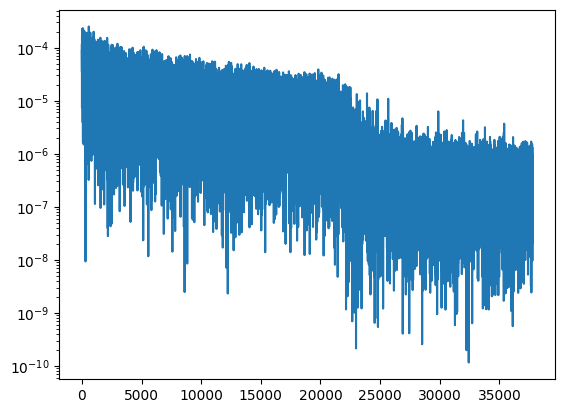

In [147]:
plt.plot(np.abs(np.diff(-Es_clip_std[star_index:end_index].sum(1)/Es_clip[star_index:end_index].sum(1)/(4096)**0.5)))
plt.yscale('log')

In [21]:
E = Es_clip1[-1000:].mean(0).real
print(E, E-E[0])

[-8.069876  -7.949546  -7.9363275 -7.9137096 -7.913072 ] [0.         0.12032986 0.13354826 0.15616608 0.15680361]


In [20]:
Es_clip_std[star_index:end_index].mean(1)/(4096)**0.5

array([0.00247741, 0.00243213, 0.00285433, ..., 0.00029603, 0.00029176,
       0.00028755], dtype=float32)

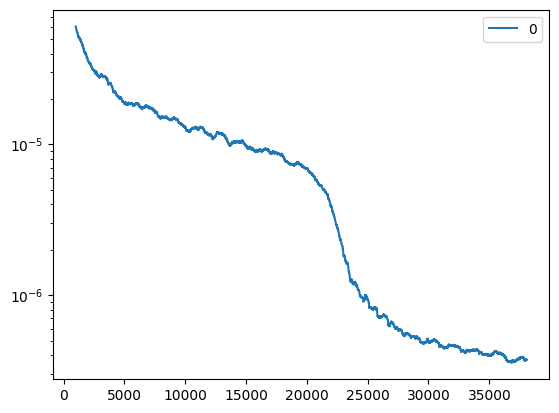

In [212]:
(pd.DataFrame(np.abs(np.diff(-Es_clip_std[star_index:end_index].sum(1)/Es_clip[star_index:end_index].sum(1)/(4096)**0.5))).rolling(1000).mean()).plot()
plt.yscale('log')

In [103]:
Es_clip1.real[-1000:].mean(0)-Es_clip1.real[-1000:].mean(0)[0]

array([0.        , 0.26820374, 0.28258514, 0.34085846, 0.34868622],
      dtype=float32)

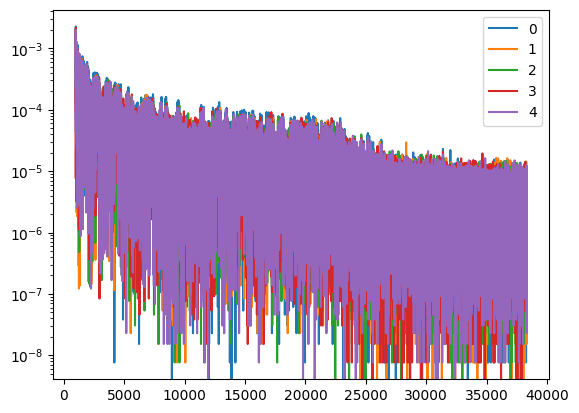

In [153]:
pd.DataFrame(Es_clip).rolling(1000).mean().diff().abs().plot()
plt.yscale('log')

In [173]:
Es_clip_std/(4096)**0.5

array([[0.05917101, 0.05127358, 0.054593  , 0.05675337, 0.05521212],
       [0.14687753, 0.13599369, 0.13787256, 0.12221058, 0.13221572],
       [0.12195132, 0.12142253, 0.12651339, 0.12869285, 0.1279062 ],
       ...,
       [0.00158062, 0.00144673, 0.00142549, 0.00146735, 0.00145566],
       [0.00160751, 0.00139517, 0.00141945, 0.0014667 , 0.0014235 ],
       [0.0015878 , 0.00148118, 0.00153042, 0.00144572, 0.0014893 ]],
      dtype=float32)

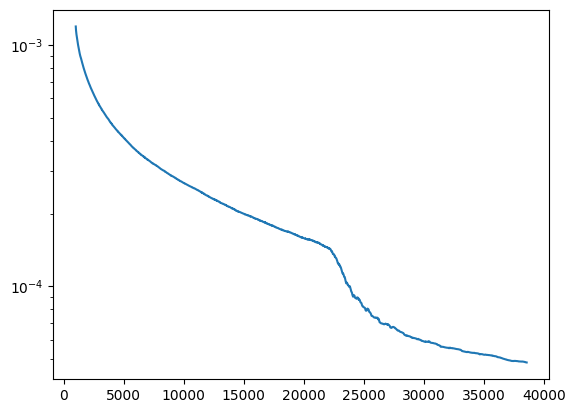

In [218]:
(pd.DataFrame(Es_clip_std).rolling(1000).mean()/(1000*4096)**0.5).mean(1).plot()
plt.yscale('log')

/home/liujinde/anaconda3/envs/ferminet/lib/python3.12/site-packages/pandas/core/window/rolling.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


<Axes: >

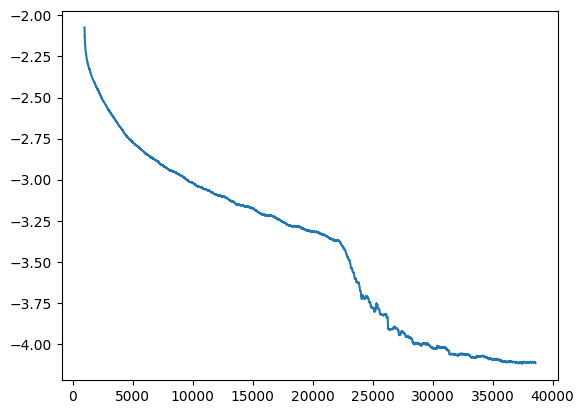

In [221]:
np.log10((pd.DataFrame(Es_clip1).rolling(1000).std()/(1000)**0.5).mean(1)).plot()

# 自注意力模块的交换反对称

In [267]:
x = np.random.randn(2,3)

Qw = np.random.randn(3,3)
Kw = np.random.randn(3,3)
Vw = np.random.randn(3,3)
W = np.random.randn(3,3)
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))
Q = x@Qw
K = x@Kw
V = x@Vw

A = softmax(Q@K.T/3**0.5)@V
x[[0,1], :] = x[[1,0], :]
Q = x@Qw
K = x@Kw
V = x@Vw
B = A@W
A1 = softmax(Q@K.T/3**0.5)@V
B1 = A1@W

print(B,B1)

[[-0.28397036  2.1463305   0.11651421]
 [ 0.03077776  1.51069406  0.39706695]] [[ 0.03077776  1.51069406  0.39706695]
 [-0.28397036  2.1463305   0.11651421]]


### 交换等变性证明

我们需要证明在 `x` 的两行交换后，注意力矩阵 `A` 的行也会相应交换，证明该计算过程满足交换反对称性。

#### 1. 定义变量
设输入矩阵 $ x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} $，其中 $ x_1 $ 和 $ x_2 $ 分别代表 $ x $ 的两行向量（行向量）。

矩阵 `Qw`、`Kw` 和 `Vw` 分别是 $ 3 \times 3 $ 的权重矩阵，用于计算查询矩阵 `Q`、键矩阵 `K` 和值矩阵 `V`。

#### 2. 计算 $ Q $, $ K $, $ V $
根据矩阵运算定义：
$$
Q = x \cdot Qw = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \cdot Qw = \begin{bmatrix} x_1 \cdot Qw \\ x_2 \cdot Qw \end{bmatrix}
$$
$$
K = x \cdot Kw = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \cdot Kw = \begin{bmatrix} x_1 \cdot Kw \\ x_2 \cdot Kw \end{bmatrix}
$$
$$
V = x \cdot Vw = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \cdot Vw = \begin{bmatrix} x_1 \cdot Vw \\ x_2 \cdot Vw \end{bmatrix}
$$

#### 3. 计算注意力矩阵 $ A $
注意力矩阵的计算公式为：
$$
A = \text{softmax}\left(\frac{Q K^T}{\sqrt{3}}\right) \cdot V
$$

由于 `softmax` 操作在每行上进行，我们可以将注意力矩阵表示为两个分量：
$$
A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}
$$
其中
$$
A_{11} = \text{softmax}\left(\frac{Q_1 \cdot K^T}{\sqrt{3}}\right) \cdot V_1, \quad A_{21} = \text{softmax}\left(\frac{Q_2 \cdot K^T}{\sqrt{3}}\right) \cdot V_2
$$

#### 4. 行交换操作
代码中执行 `x[[0,1], :] = x[[1,0], :]` 将 `x` 的行进行交换。这意味着交换了输入矩阵 `x` 的两行，使新的 $ x' = \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} $。

经过交换后，新计算的 $ Q' $、$ K' $ 和 $ V' $ 为：
$$
Q' = x' \cdot Qw = \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} \cdot Qw = \begin{bmatrix} x_2 \cdot Qw \\ x_1 \cdot Qw \end{bmatrix}
$$
$$
K' = x' \cdot Kw = \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} \cdot Kw = \begin{bmatrix} x_2 \cdot Kw \\ x_1 \cdot Kw \end{bmatrix}
$$
$$
V' = x' \cdot Vw = \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} \cdot Vw = \begin{bmatrix} x_2 \cdot Vw \\ x_1 \cdot Vw \end{bmatrix}
$$

#### 5. 计算新的注意力矩阵 $ A' $
使用新矩阵 $ Q' $、$ K' $、$ V' $ 计算新的注意力矩阵：
$$
A' = \text{softmax}\left(\frac{Q' \cdot K'^T}{\sqrt{3}}\right) \cdot V'
$$

将 $ Q' $、$ K' $、$ V' $ 代入，我们发现 $ A' $ 的计算是将原来 $ A $ 中的行交换，即：
$$
A' = \begin{bmatrix} A_{21} & A_{22} \\ A_{11} & A_{12} \end{bmatrix}
$$

#### 结论
由此可以得出结论：在交换 `x` 的两行后，计算得到的注意力矩阵 $ A' $ 也相应地交换了原来的行。

因此，该计算过程满足交换反对称性。


In [287]:
import numpy as np

# 初始化输入矩阵 x 和权重矩阵 Qw, Kw, Vw
x = np.random.randn(10, 8)
Qw = np.random.randn(8, 8)
Kw = np.random.randn(8, 8)
Vw = np.random.randn(8, 8)
def phi(x):
    # 核函数（可以调整为不同的激活函数，如 ReLU, ELU 等）
    return (x)
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

# 计算 Q, K, V 矩阵
Q = x @ Qw
K = x @ Kw
V = x @ Vw

QK_T = Q @ K.T / 8**0.5

A = softmax(QK_T) @ V

# 计算 Q, K, V 矩阵
Q = phi(x @ Qw)
K = phi(x @ Kw)
V = x @ Vw

# 计算加权和值
KV = K.T @ V
Z = 1 / (Q @ K.T @ np.ones(K.shape[0]))

# 计算线性注意力矩阵 A
A1 = (Q @ KV) * Z[:, None]

# 打印结果
print("A =", A)
print("A1 =", A1)


A = [[ 2.77463893  2.48522116  1.67120304  0.72335338 -0.71073382 -2.92232264
  -4.26614769  2.835692  ]
 [-2.14694435 -1.1760644   0.43154215 -0.8741601   0.64395692  1.92196401
   0.54862097  0.31533322]
 [-2.17130705 -2.44173986  2.48974772  1.22162857  1.92529584  3.57674776
  -0.83838296 -1.08671191]
 [ 4.2684607   2.94257654  1.53198816  2.31502457  0.07620507 -1.77383122
  -2.84462729  1.05466679]
 [ 2.52217088  2.29953048  1.68877801  0.58962209 -0.69534252 -2.75197329
  -4.24437925  2.71108666]
 [-2.02696723 -2.42158771  2.35120338  1.41241363  1.8232791   3.50906313
  -0.77295408 -1.21124906]
 [ 2.27805326  0.59614189  1.86893455  1.4577335  -0.37056292 -0.37224202
  -1.97967383  0.64281026]
 [ 0.16247651 -0.24946418  1.17896096 -1.38759181 -1.29450384 -0.77612825
  -2.63312861  0.01624604]
 [ 2.89877334  2.585311    1.67160426  0.80365536 -0.70421052 -3.00537376
  -4.28864432  2.91471452]
 [ 2.88983931  2.50767597  1.65706113  0.89956536 -0.61670057 -2.82360664
  -4.1325584 

In [248]:
from itertools import combinations

# 总轨道数
n_orbitals = 7
# 总电子数
n_electrons = 5

# 生成所有可能的占据组合
positions = list(combinations(range(n_orbitals), n_electrons))
S = np.zeros((7,5,len(positions)))
for i in range(len(positions)):
    for j in range(5):
        S[positions[i][j],j,i]=1

1111100
1111010
1111001
1110110
1110101
1110011
1101110
1101101
1101011
1100111
1011110
1011101
1011011
1010111
1001111
0111110
0111101
0111011
0110111
0101111
0011111


21

In [258]:
S[:,:,4]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [247]:
5*4+5

25

/home/liujinde/anaconda3/envs/ferminet/lib/python3.12/site-packages/pandas/core/window/rolling.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


<Axes: >

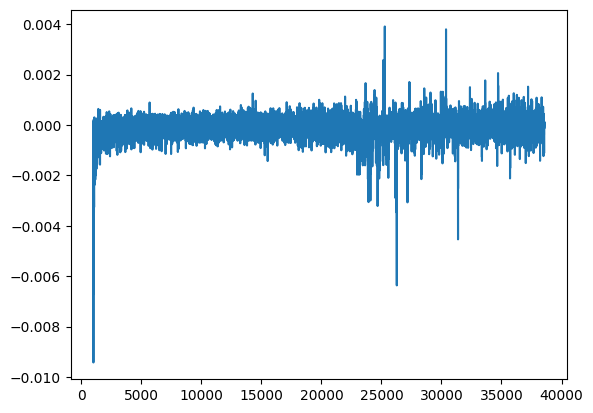

In [219]:
np.log10((pd.DataFrame(Es_clip1).rolling(1000).std()/(1000)**0.5).mean(1)).diff().plot()
# plt.yscale('log')

In [209]:
(1*((pd.DataFrame(Es_clip1).rolling(1000, min_periods=1).std()/(1000)**0.5).mean(1)>4e-5)).sum()

/home/liujinde/anaconda3/envs/ferminet/lib/python3.12/site-packages/pandas/core/window/rolling.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


np.int64(38566)

In [183]:
(pd.DataFrame(Es_clip_std).rolling(1000).mean()/(4096*1000)**0.5).loc[30000]

0    0.000062
1    0.000058
2    0.000058
3    0.000058
4    0.000059
Name: 30000, dtype: float64

In [72]:
root_path = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/AE/Psiformer/Moleculer/BeH_ccecp/'
# root_path = "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/AE/Ferminet/Moleculer/BeH_AE/"
Es = []
E_var = []
for term in sorted(os.listdir(root_path)):
    file_name = root_path+term+'/'+'train_stats.csv'
    data = pd.read_csv(file_name, index_col=1)
    Es.append(data['E_mean_clip'])
    E_var.append(data['E_var_clip'])

In [73]:
E = pd.DataFrame(Es).T.loc[17000:18000].mean(0).to_numpy()
sorted(E-E[0])

[np.float64(0.0),
 np.float64(0.09060254745255669),
 np.float64(0.090837485014994),
 np.float64(0.20293132217783239),
 np.float64(0.20850189610390757),
 np.float64(0.2161282077922042),
 np.float64(0.21672346703298828),
 np.float64(0.2243723446553414),
 np.float64(0.23172861338664852),
 np.float64(0.23251570129873045),
 np.float64(0.2468035274725544)]

In [74]:
E

array([-15.24619942, -15.15559687, -15.15536194, -15.0432681 ,
       -15.03769752, -15.03007121, -15.02182708, -15.02947595,
       -15.01368372, -14.99939589, -15.01447081])

In [71]:
E

array([-15.24793771, -15.15593853, -15.15639777, -15.0385308 ,
       -15.0307274 , -15.03051444, -15.03909501, -15.01591874,
       -15.01303963, -14.99832065])

In [ ]:
[np.float64(0.0),
 np.float64(0.09060254745255669),
 np.float64(0.090837485014994),
 np.float64(0.20293132217783239),
 np.float64(0.20850189610390757),
 np.float64(0.2161282077922042),
 np.float64(0.21672346703298828),
 np.float64(0.2243723446553414),
 np.float64(0.23172861338664852),
 np.float64(0.23251570129873045),
 np.float64(0.2468035274725544)]

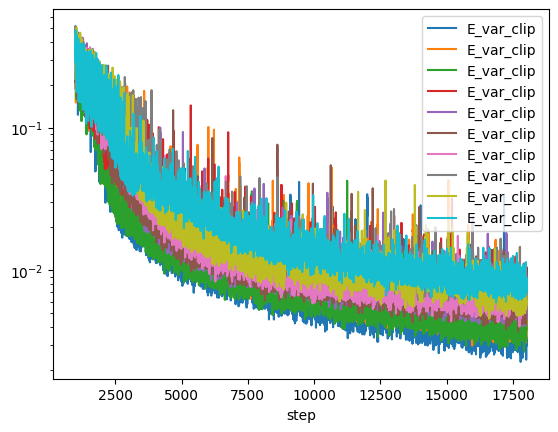

In [69]:
pd.DataFrame(E_var).T.loc[1000:18000].plot()
plt.yscale('log')

In [305]:
root_path

'../EXP/NES/Mol_psiformer/H2O1/'

In [ ]:
from ferminet import checkpoint
import jax

file_names = [
    '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_psiformer/H2O/qmcjax_ckpt_038507.npz',
    '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_psiformer/H2O/qmcjax_ckpt_038412.npz',
]
params = []
for file in file_names:
    t, data, param, opt_state, mcmc_width, density_state=checkpoint.restore(file, 4096)
    params.append(param)

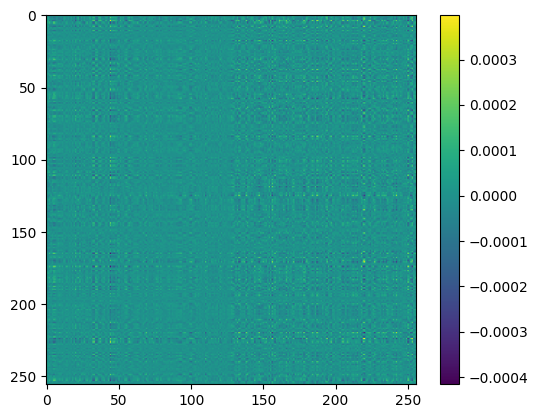

In [14]:
import matplotlib.pyplot as plt
plt.imshow(params[0]['layers']['attention'][0]['v_w'][0]-params[1]['layers']['attention'][0]['v_w'][0])
plt.colorbar()
plt.show()
# plt.imshow(params[1]['layers']['attention'][0]['q_w'][0])
# plt.colorbar()
# plt.show()

In [42]:
jax.tree_util.tree_map(lambda x: x.shape, params[0])

NameError: name 'jax' is not defined

In [50]:
from ferminet import checkpoint
import jax
import os

root = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol_psiformer/H2O/'
sigmas = []
for name in sorted(os.listdir(root))[-10:]:
    if 'qmcjax_ckpt_' in name:
        filename = root+name
        t, data, params, opt_state, mcmc_width, density_state=checkpoint.restore(filename, 4096)
        params = jax.tree_util.tree_map(lambda x: jax.device_get(x)[0], params)
        import jax.tree_util as jtu
        # sigmas.append(params['layers']['attention'][1]['k_w'].reshape(1,-1))
        sigmas.append(params['orbital'][0]['w'].reshape(1,-1))
        # 定义提取参数值的函数
        # def extract_param(param):
        #     return param.flatten()  # 将参数展平为一维
        # plt.plot(sigmas[-1])

        # # 使用 tree_map 遍历所有参数并提取数据
        # flat_params_list = jtu.tree_map(extract_param, params)

        # # 将所有参数展平成一个数组
        # flat_params = jnp.concatenate([p for p in jtu.tree_leaves(flat_params_list)])
        # a = plt.hist(flat_params, bins=1000)
        # plt.xlim([-0.2,0.2])

2024-11-07 12:27:17.857783: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
params

(2, 2048, 3)

 ...]

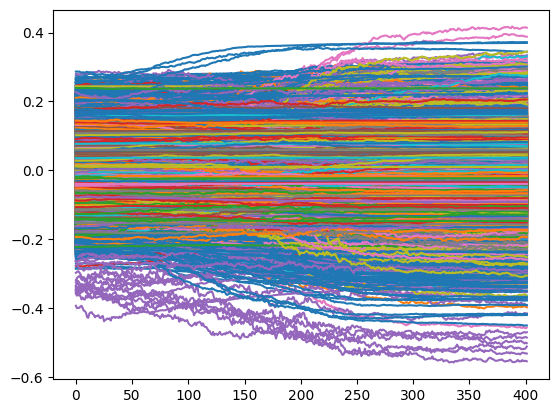

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(sigmas)

In [54]:
jax.tree_map(lambda x:x.shape, params)

/tmp/ipykernel_27297/2219421884.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x:x.shape, params)


{'HF': (5,),
 'envelope': [{'pi': (3, 800), 'sigma': (3, 800)},
  {'pi': (3, 800), 'sigma': (3, 800)}],
 'jastrow': {'ee_anti': (1,), 'ee_par': (1,)},
 'layers': {'attention': [{'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)}],
  'embed': (13, 256),
  'input': {},
  'ln': [[{'offset': (256,), 'scale': (256,)},
    {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}]],
  'mlp': [[{'b': (256,), 'w': (256, 256)}, {'b': (256,), 

In [458]:
params['orbital'][0]['w']

array([[ 0.06776104,  0.0824877 ,  0.1264364 , -0.0847945 , -0.09974614],
       [-0.01634877, -0.01826845, -0.00304233, -0.06259079, -0.01352353],
       [-0.00726674,  0.12165291,  0.02212841,  0.1006517 ,  0.00335265],
       ...,
       [ 0.0403705 ,  0.08747345, -0.05514748, -0.06528592,  0.00602651],
       [ 0.03610598, -0.03066465,  0.02345624,  0.01854658,  0.04104745],
       [ 0.05029639, -0.10048309, -0.06589115, -0.14752246, -0.09483504]],
      dtype=float32)

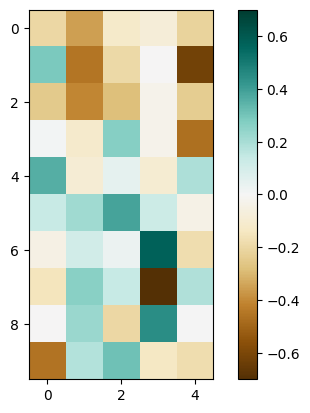

In [454]:
plt.imshow(params['psi'][0], cmap='BrBG', vmin=-0.7,vmax=0.7)
plt.colorbar()

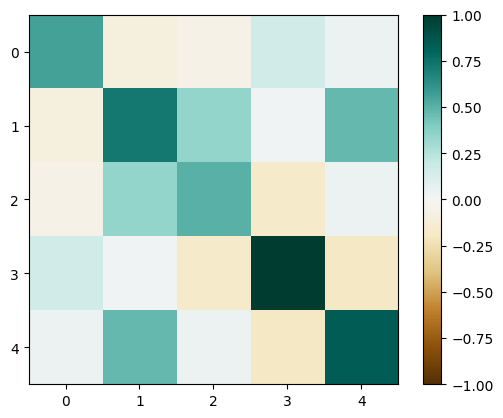

In [453]:
plt.imshow(params['psi'][0].T@params['psi'][0], cmap='BrBG', vmin=-1,vmax=1)
plt.colorbar()

In [410]:
jax.tree_util.tree_map(lambda x: x.shape, params)
{'envelope': [{'pi': (2, 5), 'sigma': (2, 5)},
  {'pi': (2, 5), 'sigma': (2, 5)}],
 'jastrow': {'ee_anti': (1,), 'ee_par': (1,)},
 'layers': {'attention': [{'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)}],
  'embed': (9, 256),
  'input': {},
  'ln': [[{'offset': (256,), 'scale': (256,)},
    {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}]],
  'mlp': [[{'b': (256,), 'w': (256, 256)}, {'b': (256,), 'w': (256, 256)}],
   [{'b': (256,), 'w': (256, 256)}, {'b': (256,), 'w': (256, 256)}],
   [{'b': (256,), 'w': (256, 256)}, {'b': (256,), 'w': (256, 256)}],
   [{'b': (256,), 'w': (256, 256)}, {'b': (256,), 'w': (256, 256)}]]},
 'orbital': [{'w': (256, 5)}, {'w': (256, 5)}],
 'psi': [(10, 5), (10, 5)]}

{'envelope': [{'pi': (2, 5), 'sigma': (2, 5)},
  {'pi': (2, 5), 'sigma': (2, 5)}],
 'jastrow': {'ee_anti': (1,), 'ee_par': (1,)},
 'layers': {'attention': [{'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)},
   {'attn_output': (256, 256),
    'k_w': (256, 256),
    'q_w': (256, 256),
    'v_w': (256, 256)}],
  'embed': (9, 256),
  'input': {},
  'ln': [[{'offset': (256,), 'scale': (256,)},
    {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}],
   [{'offset': (256,), 'scale': (256,)}, {'offset': (256,), 'scale': (256,)}]],
  'mlp': [[{'b': (256,), 'w': (256, 256)}, {'b': (256,), 'w': (256, 256)}],
   

INFO:absl:Loading checkpoint ../EXP/NES/Mol/LiH/qmcjax_ckpt_000773.npz
INFO:absl:Loading checkpoint ../EXP/NES/Mol/LiH/qmcjax_ckpt_001629.npz
INFO:absl:Loading checkpoint ../EXP/NES/Mol/LiH/qmcjax_ckpt_002481.npz


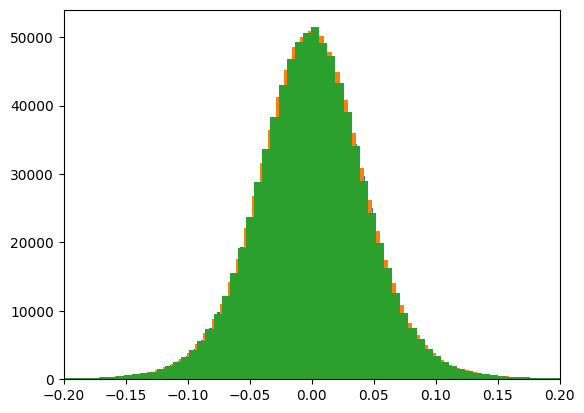

In [698]:
from ferminet import checkpoint
import jax

root = root_path

for name in sorted(os.listdir(root)):
    if 'qmcjax_ckpt_' in name:
        filename = root+name
        t, data, params, opt_state, mcmc_width, density_state=checkpoint.restore(filename, 4096)
        params = jax.tree_util.tree_map(lambda x: jax.device_get(x)[0], params)
        import jax.tree_util as jtu

        # 定义提取参数值的函数
        def extract_param(param):
            return param.flatten()  # 将参数展平为一维

        # 使用 tree_map 遍历所有参数并提取数据
        flat_params_list = jtu.tree_map(extract_param, params)

        # 将所有参数展平成一个数组
        flat_params = jnp.concatenate([p for p in jtu.tree_leaves(flat_params_list)])
        a = plt.hist(flat_params, bins=1000)
        plt.xlim([-0.2,0.2])

In [3]:
from ferminet import checkpoint
import jax
import os
import matplotlib.pyplot as plt

root = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/LiH1/'
sigmas = []
for name in sorted(os.listdir(root)):
    if 'qmcjax_ckpt_' in name:
        filename = root+name
        t, data, params, opt_state, mcmc_width, density_state=checkpoint.restore(filename, 4096)
        params = jax.tree_util.tree_map(lambda x: jax.device_get(x)[0], params)
        import jax.tree_util as jtu
        sigmas.append(params['layers']['streams'][0]['single']['w'])
        # 定义提取参数值的函数
        # def extract_param(param):
        #     return param.flatten()  # 将参数展平为一维
        # plt.plot(sigmas[-1])
plt.plot(np.array(sigmas)[:,-1])
        # # 使用 tree_map 遍历所有参数并提取数据
        # flat_params_list = jtu.tree_map(extract_param, params)

        # # 将所有参数展平成一个数组
        # flat_params = jnp.concatenate([p for p in jtu.tree_leaves(flat_params_list)])
        # a = plt.hist(flat_params, bins=1000)
        # plt.xlim([-0.2,0.2])

2024-10-27 14:49:05.910578: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


NameError: name 'plt' is not defined

In [620]:
from pyscf import gto,scf

LiH_mol = gto.Mole()
LiH_mol.build(
    atom=f'Cl 0 0 0; H 1.595 0 0',
    basis={'Cl': 'ccpvtz', 'H': 'ccpvtz'},
    spin=0)

mf = scf.UHF(LiH_mol)
mf.kernel()
mf.mo_coeff.shape

converged SCF energy = -460.065615738902  <S^2> = 1.7188029e-11  2S+1 = 1


(2, 48, 48)

In [577]:
from ferminet import checkpoint
import jax
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.tree_util as jtu
import seaborn as sns
import numpy as np

root = "/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/"

# 设置图像大小
plt.figure(figsize=(12, 6))

# 获取符合条件的文件列表
checkpoint_files = sorted([name for name in os.listdir(root) if 'qmcjax_ckpt_' in name])

# 为渐变颜色创建颜色映射
num_files = len(checkpoint_files)
colors = plt.cm.viridis(np.linspace(0, 1, num_files))


datas = []
# 遍历所有符合条件的文件并绘制概率密度曲线
for idx, name in enumerate(checkpoint_files):
    filename = os.path.join(root, name)
    t, data, params, opt_state, mcmc_width, density_state = checkpoint.restore(filename, 4096)
    params = jtu.tree_map(lambda x: jax.device_get(x)[0], params)

    # 定义提取参数值的函数
    def extract_param(param):
        return param.flatten()  # 将参数展平为一维

    # 使用 tree_map 遍历所有参数并提取数据
    flat_params_list = jtu.tree_map(extract_param, params)

    # 将所有参数展平成一个数组
    flat_params = jnp.concatenate([p for p in jtu.tree_leaves(flat_params_list)])
    datas.append(flat_params)


INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_000432.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_000909.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_001387.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_001868.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_002350.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_002829.npz
INFO:absl:Loading checkpoint /home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/EXP/NES/Mol/BH_test1/qmcjax_ckpt_003308.npz

<Figure size 1200x600 with 0 Axes>

In [578]:
params

{'HF': array([0.94953376], dtype=float32),
 'envelope': [{'pi': array([[ 0.978291  ,  0.9753821 ,  0.9176886 ,  0.904772  ,  0.9483092 ,
            0.93543464,  0.9976075 ,  0.9960449 ,  0.9992588 ,  0.9971517 ,
            0.99724174,  0.9989197 ,  1.001099  ,  0.9979047 ,  0.9981576 ,
            0.99828243,  0.9966894 ,  0.9980356 ,  1.0106655 ,  0.99517816,
            0.9865809 ,  1.0094864 ,  1.0033876 ,  0.99624074,  0.9959301 ,
            0.99720806,  1.0014257 ,  0.9740627 ,  0.94990796,  0.9900581 ,
            1.0053157 ,  1.0013543 ,  1.0008469 ,  1.0154537 ,  1.0030551 ,
            1.0004869 ,  0.94334036,  0.9151053 ,  0.9760187 ,  0.9183065 ,
            0.9327822 ,  0.97358346,  0.9809153 ,  0.96061414,  0.9217674 ,
            0.9463944 ,  0.9499077 ,  1.0147126 ,  0.99826217,  0.9986258 ,
            0.99737996,  0.99723357,  0.9971596 ,  0.99826545,  0.99812025,
            0.99733937,  0.99744576,  0.9969838 ,  0.99866426,  0.9961453 ,
            0.0952201 ,  1.

In [129]:
from scipy.stats import gaussian_kde
kdes = []
for d in datas:
    kde = gaussian_kde(d, bw_method=0.5)
    x_vals = jnp.linspace(-0.2, 0.2, 500)
    y_vals = kde(x_vals)
    kdes.append(y_vals)

KeyboardInterrupt: 

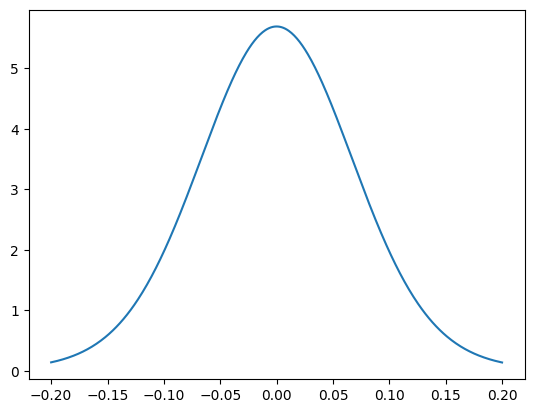

In [128]:
plt.plot(x_vals, y_vals)

[-25.28277336 -25.2434558  -25.22784308 -25.20325602 -25.18051814] [np.float64(-25.278550134135763), np.float64(-25.222654498695), np.float64(-25.21248812003372), np.float64(-25.212470089906617), np.float64(-25.211683559628224)]
[0.         0.03931756 0.05493028 0.07951734 0.10225522] [0.         0.05589564 0.06606201 0.06608004 0.06686657]


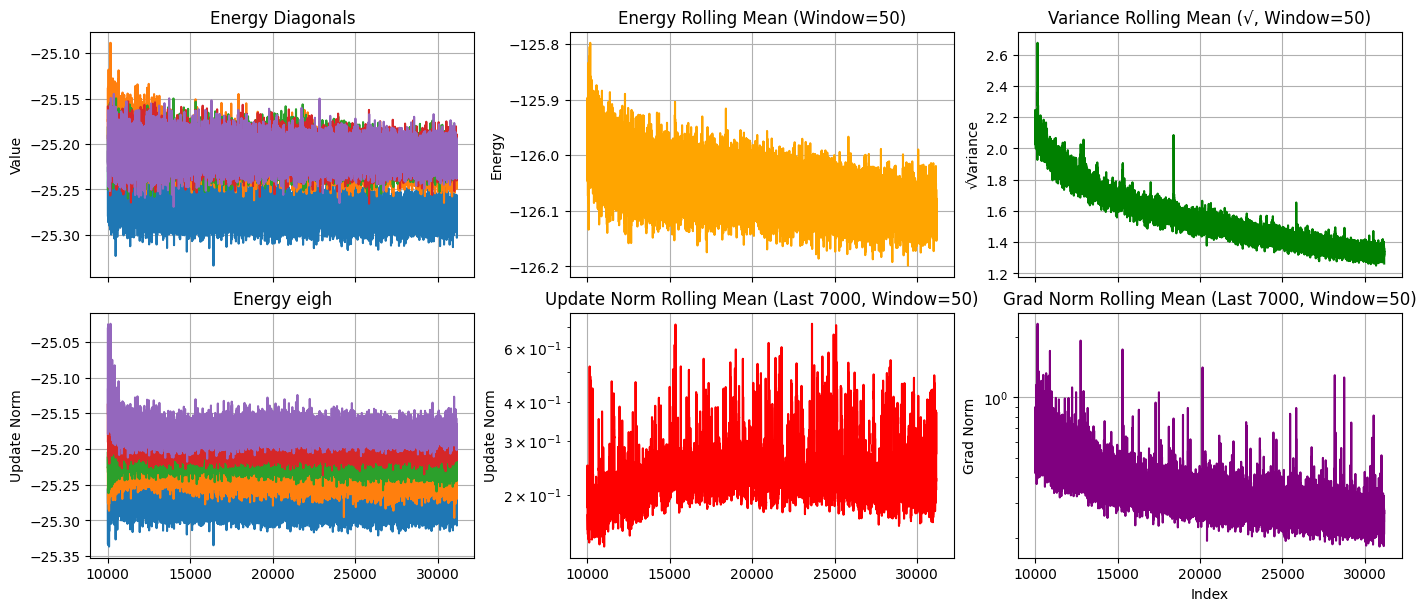

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/ferminet/NES/Mol/BH_adam1/train_stats2024_10_21_23:05:34.csv")
data = data.set_index('step')
data = data.reset_index()
indexs = ['E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9',
       'E_10', 'E_11', 'E_12', 'E_13', 'E_14', 'E_15', 'E_16', 'E_17', 'E_18',
       'E_19', 'E_20', 'E_21', 'E_22', 'E_23', 'E_24']
indexs2 = ['E_0n', 'E_1n', 'E_2n', 'E_3n', 'E_4n', 'E_5n', 'E_6n', 'E_7n', 'E_8n',
       'E_9n', 'E_10n', 'E_11n', 'E_12n', 'E_13n', 'E_14n', 'E_15n', 'E_16n',
       'E_17n', 'E_18n', 'E_19n', 'E_20n', 'E_21n', 'E_22n', 'E_23n', 'E_24n']
for m in indexs:
    x = [data[m][0]]
    V = [data[m][0]]
    previous = data[m][0]
    previous_V = data[m][0]
    for i in range(data.shape[0]-1):
        observation = data[m][i+1]
        previous = (observation - previous)*0.1 + previous
        previous_V = ((observation - previous)**2*0.1 + previous_V)*0.9
        x.append(previous)
        V.append(previous_V)

    data[m+'n'] = x
    # data[m+'n_var'] = V
# Es = []
# E_m = data[indexs].to_numpy().reshape(data.shape[0],5,5)
# for i in range(0, data.shape[0]):
#     Es.append(np.diagonal(E_m[i]))
#     # Es.append(np.linalg.eigh(E_m[i])[0])
# 构建 Es 列表
E_m = data[indexs].to_numpy().reshape(data.shape[0], 5, 5)
Es = [np.diagonal(E_m[i]) for i in range(data.shape[0])]
Es1 = [np.linalg.eigh(E_m[i])[0] for i in range(data.shape[0])]

E_m = data[indexs2].to_numpy().reshape(data.shape[0],5,5)[-1000:,:,:]
E,U=np.linalg.eigh(E_m.mean(0))
E1 = sorted(np.diagonal(E_m.mean(0)))
print(E, E1)
print(E-E[0], E1-E1[0])
# 创建紧凑的子图布局，例如 3 行 2 列，且共享 x 轴
fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)

lost_index = 10000
# 子图 1: Es 的绘图
axes[0, 0].plot(data['step'][lost_index:], Es[lost_index:], alpha=1)
axes[0, 0].set_title('Energy Diagonals')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True)

# 子图 2: energy 的滚动平均（示例中使用 window=50 进行平滑）
axes[0, 1].plot(data['energy'].rolling(window=1).mean()[lost_index:], color='orange')
axes[0, 1].set_title('Energy Rolling Mean (Window=50)')
axes[0, 1].set_ylabel('Energy')
axes[0, 1].grid(True)

# 子图 3: var 的滚动平均开方（示例中使用 window=50 进行平滑）
axes[0, 2].plot(((data['var'].rolling(window=1).mean())**0.5)[lost_index:], color='green')
axes[0, 2].set_title('Variance Rolling Mean (√, Window=50)')
axes[0, 2].set_ylabel('√Variance')
axes[0, 2].grid(True)

# 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 0].plot(data['step'][lost_index:], Es1[lost_index:])
axes[1, 0].set_title('Energy eigh')
axes[1, 0].set_ylabel('Update Norm')
axes[1, 0].grid(True)

# 子图 4: update_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 1].plot(data['update_norm'].rolling(window=1).mean().iloc[lost_index:], color='red')
axes[1, 1].set_title('Update Norm Rolling Mean (Last 7000, Window=50)')
axes[1, 1].set_ylabel('Update Norm')
axes[1, 1].set_yscale("log")
axes[1, 1].grid(True)

# 子图 5: grad_norm 的滚动平均（取最后 7000 个点，window=50）
axes[1, 2].plot(data['grad_norm'].rolling(window=1).mean().iloc[lost_index:], color='purple')
axes[1, 2].set_title('Grad Norm Rolling Mean (Last 7000, Window=50)')
axes[1, 2].set_ylabel('Grad Norm')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_yscale("log")
axes[1, 2].grid(True)

# 隐藏子图 6（如果不需要）
# fig.delaxes(axes[1, 2])

plt.show()

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.device_count()

2

In [13]:
num_devices = jax.local_device_count()
num_hosts = jax.device_count() // num_devices
num_states = 5  # avoid 0/1 confusion
host_batch_size = 4096 // num_hosts  # batch size per host
total_host_batch_size = host_batch_size * num_states
device_batch_size = host_batch_size // num_devices  # batch size per device
data_shape = (num_devices, device_batch_size)

In [48]:
from ferminet import networks
import jax.numpy as jnp
import numpy as np
restore_filename = '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/ferminet/NES/Mol/BH_sgd4/qmcjax_ckpt_045092.npz'
with open(restore_filename, 'rb') as f:
    ckpt_data = np.load(f, allow_pickle=True)
    # Retrieve data from npz file. Non-array variables need to be converted back
    # to natives types using .tolist().
    t = ckpt_data['t'].tolist() + 1  # Return the iterations completed.
    data = networks.FermiNetData(**ckpt_data['data'].item())
    data_new = jax.tree_util.tree_map(lambda x: x.reshape(data_shape+x.shape[2:]), data)
    params = ckpt_data['params'].tolist()
    params = jax.tree_util.tree_map(lambda x: jax.device_get(x)[0], params)
    opt_state = ckpt_data['opt_state'].tolist()
    mcmc_width = jnp.array(ckpt_data['mcmc_width'].tolist())

In [50]:
mcmc_width

Array([0.10108943, 0.10108943], dtype=float32)

In [27]:
gather_to_host_pos.positions.shape

(2048, 90)

In [25]:
mcmc_width

Array([0.10108943, 0.10108943], dtype=float32)

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/ferminet/train_stats.csv')
data = data.set_index('step')
data = data.reset_index()
indexs = ['E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9',
       'E_10', 'E_11', 'E_12', 'E_13', 'E_14', 'E_15', 'E_16', 'E_17', 'E_18',
       'E_19', 'E_20', 'E_21', 'E_22', 'E_23', 'E_24']
indexs2 = ['E_0n', 'E_1n', 'E_2n', 'E_3n', 'E_4n', 'E_5n', 'E_6n', 'E_7n', 'E_8n',
       'E_9n', 'E_10n', 'E_11n', 'E_12n', 'E_13n', 'E_14n', 'E_15n', 'E_16n',
       'E_17n', 'E_18n', 'E_19n', 'E_20n', 'E_21n', 'E_22n', 'E_23n', 'E_24n']
for m in indexs:
    x = [data[m][0]]
    V = [data[m][0]]
    previous = data[m][0]
    previous_V = data[m][0]
    for i in range(data.shape[0]-1):
        observation = data[m][i+1]
        previous = (observation - previous)*0.1 + previous
        previous_V = ((observation - previous)**2*0.1 + previous_V)*0.9
        x.append(previous)
        V.append(previous_V)

    data[m+'n'] = x
    # data[m+'n_var'] = V
# Es = []
# E_m = data[indexs].to_numpy().reshape(data.shape[0],5,5)
# for i in range(0, data.shape[0]):
#     Es.append(np.diagonal(E_m[i]))
#     # Es.append(np.linalg.eigh(E_m[i])[0])
# 构建 Es 列表
E_m = data[indexs].rolling(window=1000).mean().to_numpy().reshape(data.shape[0], 5, 5)
Es = [np.diagonal(E_m[i]) for i in range(500,data.shape[0])]
Es1 = [np.linalg.eigh(E_m[i])[0] for i in range(1000,data.shape[0])]

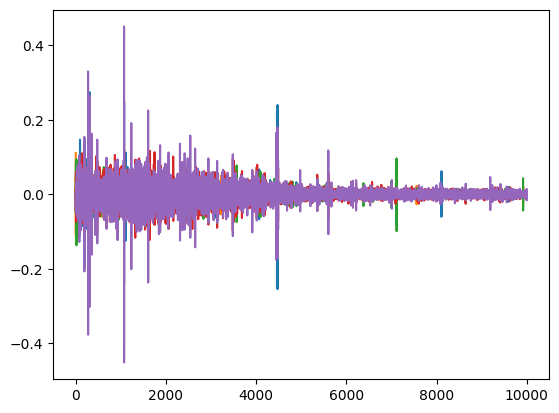

In [170]:
E_m = data[indexs].rolling(window=1).mean().to_numpy().reshape(data.shape[0], 5, 5)
Es = [np.diagonal(E_m[i]) for i in range(0,data.shape[0])]
Es1 = [np.linalg.eigh(E_m[i])[0] for i in range(0,data.shape[0])]
plt.plot(np.diff(Es1, axis=0)[:10000])
# plt.yscale('log')

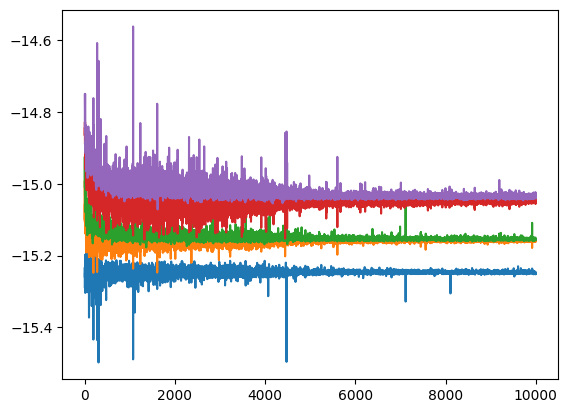

In [171]:
plt.plot(Es1[:10000])

In [71]:
import os
import pandas as pd
# sys_paths = ['/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/AE/Ferminet/Moleculer/LiH_AE',
#     # '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/AE/Psiformer/Moleculer/LiH_ccecp',
#     '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/ccECP/Ferminet/Moleculer/LiH_ccecp']

# sys_paths = ['/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/AE/Ferminet/Moleculer/BeH_AE',
#              '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/ccECP/Ferminet/Moleculer/BeH_ccecp']

sys_paths = [
    '/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/all/Ferminet/Moleculer/BeH_ccecp'
]

datass = []
for sys_path in sys_paths:
    files = os.listdir(sys_path)
    datas = []
    for file in sorted(files):
        file_name = sys_path+'/'+file+'/train_stats.csv'
        if 'ferminet_2024' in file and os.path.exists(file_name):
            data = pd.read_csv(file_name)
            if data.shape[0]!=200000:
                break
            E0 = data['E_mean_clip']
            V0 = data['E_var_clip']
            x = [E0[0]]
            V = [V0[0]]
            previous = E0[0]
            previous_V = V0[0]
            for i in range(199999):
                observation = E0[i+1]
                previous = (observation - previous)*0.1 + previous
                previous_V = ((observation - previous)**2*0.1 + previous_V)*0.9
                x.append(previous)
                V.append(previous_V)

            data['E_mean_clip_exp'] = x
            data['E_var_clip_exp'] = V

            E0 = data['E_mean']
            V0 = data['E_var']
            x = [E0[0]]
            V = [V0[0]]
            previous = E0[0]
            previous_V = V0[0]
            for i in range(199999):
                observation = E0[i+1]
                previous = (observation - previous)*0.1 + previous
                previous_V = ((observation - previous)**2*0.1 + previous_V)*0.9
                x.append(previous)
                V.append(previous_V)

            data['E_mean_exp'] = x
            data['E_var_exp'] = V
            datas.append(data)
    datass.append(datas)
# plt.ylim([-0.8,-0.5])

In [38]:
data = pd.read_csv('/home/liujinde/data/home/liujinde/deep_wavafunction/Excited_Calculate/Exp/IPF/all/Ferminet/Moleculer/BeH_ccecp/ferminet_2024_10_14_16:14:36/train_stats.csv')

In [44]:
data[67460:67480].to_excel('IPF.xlsx')

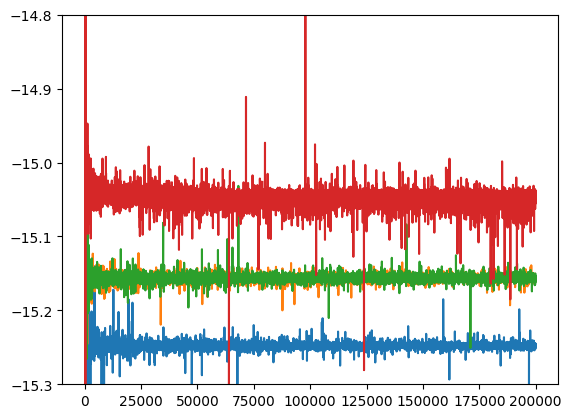

In [73]:
import matplotlib.pyplot as plt
for datas in datass:
    Es = []
    for d in datas:
        (d['E_mean']).plot()
        Es.append(d['E_mean_clip_exp'])
    # plt.yscale('log')
    plt.ylim([-15.3,-14.8])
    plt.show()


In [78]:
d.columns

Index(['Unnamed: 0', 'step', 'E_mean', 'E_mean_clip', 'E_var_clip', 'pmove',
       'E_var', 'V', 'T', 'V_loc', 'V_nloc', 'S', 'f', 'delta_time',
       'grad_norm', 'learning_rate', 'momentum', 'param_norm',
       'precon_grad_norm', 'update_norm', 'num_param', 'S_0', 'S_1', 'S_2',
       'f_0', 'f_1', 'f_2', 'E_mean_clip_exp', 'E_var_clip_exp', 'E_mean_exp',
       'E_var_exp'],
      dtype='object')

<Axes: >

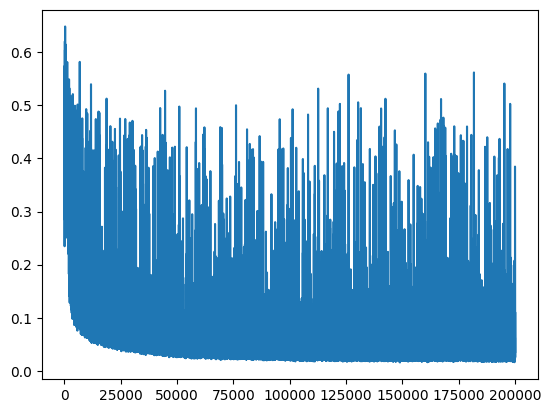

In [81]:
(d['precon_grad_norm']*0.05).plot()
# plt.ylim([0,5])
# plt.yscale('log')

<Axes: >

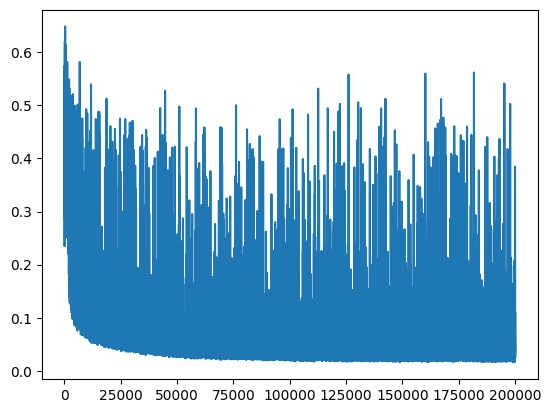

In [82]:
(d['update_norm']).plot()

(0.0, 0.5)

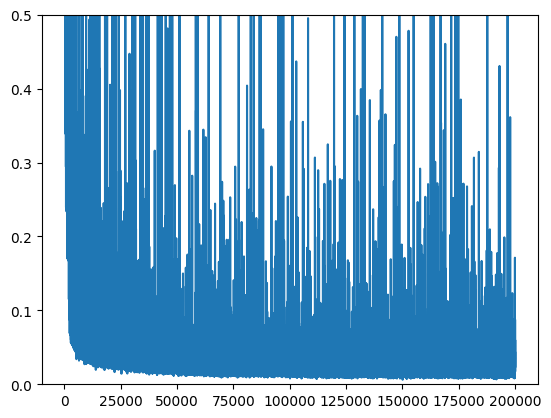

In [80]:
d['grad_norm'].plot()
plt.ylim([0,0.5])

(0.0, 0.3)

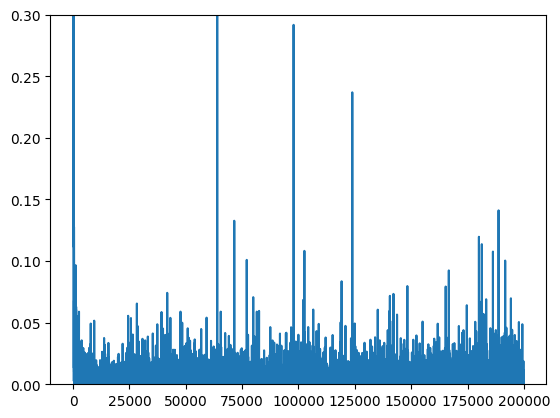

In [128]:
(d['E_mean']-d['E_mean'][-1000:].mean()).abs().plot()
plt.ylim([0,0.3])

In [31]:
# 方差匹配
E_exciteds = []
E_Vars = []
E_stds = []
for datas in datass:
    E_excited = []
    E_Var = []
    E_std = []
    V0 = datas[0]['E_var_clip_exp'].rolling(window=500, center=True, min_periods=1).mean()
    E0 = datas[0]['E_mean_clip_exp'].rolling(window=500, center=True, min_periods=1).mean()
    for d in range(0, len(datas)):
        V = datas[d]['E_var_clip_exp'][-500:].mean()
        index = (V-V0).abs().argmin()
        (datas[d]['E_mean_clip_exp'].rolling(window=500, center=True, min_periods=1).mean()-E0)
        # datas[d]['E_var_clip_exp'].rolling(window=500, center=True, min_periods=1).mean().plot()
        E_excited.append(datas[d]['E_mean_clip_exp'][-500:].mean()-E0[index])
        E_Var.append(datas[d]['E_var_clip_exp'][-500:].mean())
        E_std.append((datas[d]['E_mean_clip_exp'][-500:]).std())
    E_exciteds.append(E_excited)
    E_Vars.append(E_Var)
    E_stds.append(E_std)

In [32]:
E = np.array(E_exciteds)[0]
E-E[0]

array([0.        , 0.0911625 , 0.09098974, 0.20676894])

In [21]:
E = pd.DataFrame(Es).T.to_numpy()[-500:,:].mean(0)
E-E[0]

array([0.        , 0.09112626, 0.09098733, 0.20700095])